In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

def reproject(params, vertices, distort=False):
    R = params['R']
    T = params['T']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']

    E = np.array([
        [R[0,0], R[0,1], R[0,2], T[0]], 
        [R[1,0], R[1,1], R[1,2], T[1]], 
        [R[2,0], R[2,1], R[2,2], T[2]], 
        [0, 0, 0, 1]]).astype('double')
    
    if distort:
        k1 = params['k1']
        k2 = params['k2']
        k3 = params['k3']
        p1 = params['p1']
        p2 = params['p2']
        
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = fx * xp + cx
        v = fy * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

9.2
[04/15 14:55:31]
1.4.0


# Setup

In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device_gpu = torch.device("cuda:0")
torch.cuda.set_device(device_gpu)
device_cpu = torch.device('cpu')

print('torch.cuda.current_device():', torch.cuda.current_device())
torch.cuda.ipc_collect()
print('torch.cuda.get_device_name(0):',torch.cuda.get_device_name(0))

# print('GPU memory stats ---------------------')
# gpu_mem_stats = torch.cuda.memory_stats(device=device_gpu)
# for k, v in gpu_mem_stats.items():
#     print('  {}: {}'.format(k, v))

print(torch.cuda.memory_summary(device=device_gpu, abbreviated=False))
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))

# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))


# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce RTX 2070 SUPER
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |

# Model

In [43]:
import math
class GaussianLayer(nn.Module):
    def __init__(self, device, kernel_size, sigma, channels=4):
        super().__init__()
        self.device = device
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.channels = channels
        
        self.conv = self._get_gaussian_conv2d(kernel_size, sigma)
        self.conv.padding = int(self.kernel_size/2)
        # Given groups=3, weight of size 3 1 3 3, expected input[1, 512, 512, 4] to have 3 channels, but got 512 channels instead
        
    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(-1)
        print('x:',x.shape)
        print(self.conv.padding)
        out = self.conv(x)
        return out
    
    def _generate_gaussian_kernel(self, kernel_size, sigma, channels=4):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance + 0.00001))
        
#         gaussian_kernel = torch.sum((xy_grid - mean)**2, dim=-1)
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1).to(self.device)
        
        return gaussian_kernel
    
    def _get_gaussian_conv2d(self, kernel_size, sigma, channels=4):
        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=1, padding=int(kernel_size/2), groups=channels, bias=False).to(self.device)
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False
        return gaussian_filter

In [52]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        """
        image_size: a scalar. Only square image is supported in PyTorch3d
        """
        stat_str = ''
        
        super().__init__()
        self.device = device
        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

        self.image_size = kwargs.get('image_size', None)
        
        # set ref images: [0, 1] float32
        image_refs = kwargs.get('image_refs', None)
        self.image_refs = {}
        n_images = 0
        n_frames = 0
        for img_name, img_list in image_refs.items():
            n_frames += 1
            n_images += len(img_list)
            imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).to(self.device)
            self.image_refs[img_name] = imgs_torch
            
        # set clean_plates:
        clean_plates = kwargs.get('clean_plates', None)
        if clean_plates is not None:
            self.clean_plates = torch.from_numpy(np.array(clean_plates).astype(np.float32)).to(self.device)
            print('clean_plates:', self.clean_plates.shape)
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_path = kwargs.get('texturemap_path', None)
        texturemap = cv2.imread(texturemap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1).to(self.device)
        self.texture_map = nn.Parameter(texture_map_torch, requires_grad=True)
#         self.texture_map = texture_map_torch.clone()
        
        # batch_size
        self.batch_dict = {'img_name': [], 'cam_idx': [], 'img_idx': []}
        for cam_idx in range(16):
            i = 0
            for img_name in self.image_refs.keys():
                self.batch_dict['img_name'].append(img_name)
                self.batch_dict['cam_idx'].append(cam_idx)
                self.batch_dict['img_idx'].append(i)
                i += 1
        
        # init renderers
        self.renderer = self._init_renderer()
        
        # camera batches
        self.cam_params = kwargs.get('cam_params', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = kwargs.get('n_batch', None)
        # self.cameras = self._init_cameras(self.cam_params)
        self.cam_batches = self._init_camera_batches(self.cam_params, batch_dict=self.batch_dict, n_batch=self.n_batch, batch_size=self.batch_size)

        # set mesh
        mesh_paths = kwargs.get('mesh_paths', None)
        self.meshes = self._load_meshes_list(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch)
        # self.meshes, self.mesh_batches = self._load_mesh_batches(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch)
        
        # vertex deformations
        verts = self.meshes[0].verts_packed()
        dverts = torch.from_numpy(np.zeros(verts.shape, dtype=np.float32)).to(self.device)
        self.deform_verts = nn.Parameter(dverts, requires_grad=True)
        self.deformed_meshes = None
        
        
    def deform_meshes(self):
        self.deformed_meshes = [self.meshes[i].offset_verts(self.deform_verts) for i in range(len(self.meshes))]
        
    def forward(self, batch_idx, batch_size, deform_mesh: bool, learn_texturemap: bool, learn_deform: bool):
        losses = {'total': 0.0, 'pixel': 0.0, 'normal': 0.0, 'laplacian': 0.0}
        log = ''
        t0 = time.time()
        
        self.deform_verts.requires_grad = learn_deform
        self.texture_map.requires_grad = learn_texturemap
        
        t1 = time.time()
        log += 'forward\n'
        log += ' - {:<10}: {:.3f}s\n'.format('data prep', t1 - t0)
        
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size

        cam_indices = self.batch_dict['cam_idx'][i0:i1]
        mesh_indices = self.batch_dict['img_idx'][i0:i1]
        img_names = self.batch_dict['img_name'][i0:i1]

        t2 = time.time()
        cam_batch = self.cam_batches[batch_idx]
        meshes = [self.deformed_meshes[i] for i in mesh_indices]
        meshes = join_meshes(meshes)
        image_cur, log_render = self.renderer(meshes_world=meshes, cameras=cam_batch, texture_maps=self.texture_map)

        # shape (batch_size, W, H)
        bgs = self.clean_plates[i0:i1].squeeze()

        # merge fg, bg
        image_cur = self._merge_fg_bg(image_cur, bgs)
        # image_cur = image_cur[..., 0]
        # images_out = image_cur[...,:3]
        images_out = image_cur

        # [0, 0.1] float32
        image_refs = torch.stack([self.image_refs[img_names[i]][cam_indices[i]] for i in range(self.batch_size)]).to(self.device)
        # l_pixel = torch.mean(torch.abs(image_cur - image_refs))
        l_pixel = torch.mean(torch.sum((image_cur - image_refs)**2))

        t3 = time.time()
        log += ' - [{}/{}] {:<10}: {:.3f}s\n'.format(batch_idx+1, self.n_batch, 'batch render', t3 - t2)
        log += '   ------------------------------------\n'
        log += log_render
        log += '   ------------------------------------\n'

        l_normal = mesh_normal_consistency(meshes)
        l_laplacian = mesh_laplacian_smoothing(meshes, method='uniform')
        losses['normal'] += (l_normal / batch_size)
        losses['laplacian'] += (l_laplacian / batch_size)
        losses['pixel'] += (l_pixel / batch_size)
        # ==================================================================================== #
        
        loss = 1.0*losses['pixel'] + 0.5*losses['normal'] + 0.5*losses['laplacian']
#         loss = 1.0*losses['pixel']
        
        stat_str = self.get_gpu_stats(True)
        return loss, images_out, self.texture_map, stat_str, losses, log
    
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H]: [0, 255] uint8
        """
        out = torch.where(fg[...,0] < 1.0, fg[...,0], bg)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out

    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
        
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
        
    def _load_mesh_batches(self, device, mesh_paths, texture_map):
        meshes = load_objs_as_meshes(mesh_paths, universal_texturemap=texture_map.cpu(), device=device)
        mesh_batches = self._convert_mesh_into_batches(meshes)
        return meshes, mesh_batches
    
    def _load_meshes_list(self, device, mesh_paths, texture_map):
        meshes_list = []
        for path in mesh_paths:
            meshes_list.append(load_objs_as_meshes([path], universal_texturemap=texture_map.cpu(), device=device))
        return meshes_list
    
    
    def _convert_mesh_into_batches(self, meshes):
        mesh_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            meshes_join = []
            for i in self.batch_dict['img_idx'][i0:i1]:
                meshes_join.append(meshes[i])
            mesh_batch = join_meshes(meshes_join, include_textures=True)
            mesh_batches.append(mesh_batch)
        return mesh_batches
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_dir, vt_path=None, fname_suffix=''):
        vt_lines = []
        f_lines = []
        if vt_path is not None:
            with open(vt_path, 'r') as f:
                lines = f.readlines()
                for l in lines:
                    v = l.split(' ')
                    if v[0] == 'vt':
                        vt_lines.append(l)
                    elif v[0] == 'f':
                        f_lines.append(l)

        # normal_deforms = self.deform_verts * self.vert_normals
        dverts = self.deform_verts
        
        out_name = 'learned_mesh'
        for mesh_idx in range(len(self.meshes)):
            out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
            deformed_mesh = self.meshes[mesh_idx].offset_verts(dverts)

            verts = deformed_mesh.verts_packed()
            faces = deformed_mesh.faces_packed()
            vnormals = deformed_mesh.verts_normals_list()[0]
            fnormals = deformed_mesh.faces_normals_list()[0]

            assert(faces.shape[0] == fnormals.shape[0])
            assert(vnormals.shape[0] == verts.shape[0])

            with open(out_path, 'w+') as f:
                f.write('# OBJ file created by Hyojoon Park.\n')
                f.write('###########################\n')
                f.write('# Vertices:       {}\n'.format(verts.shape[0]))
                f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
                f.write('# Faces:          {}\n'.format(faces.shape[0]))
                f.write('###########################\n')
                f.write('mtllib learned_mesh.mtl\n')
                for i in range(verts.shape[0]):
                    f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                    f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                    
                for vtl in vt_lines:
                    f.write(vtl)
                    
                if len(f_lines) > 0:
                    for fl in f_lines:
                        f.write(fl)
                else:
                    for i in range(faces.shape[0]):
                        f.write("f")
                        face = faces[i, :]
                        for fi in range(face.shape[0]):
                            f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
        #                     f.write(' {0:.0f}'.format(face[fi]))
                        f.write("\n")

            print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(self.meshes), out_path))
        
    def _init_renderer(self):
        locations = torch.from_numpy(np.array([0, 0, 3000])).to(self.device)
        a_diffuse = 0.0
        a_ambient = 0.5
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        light = PointLights(device=self.device, location=[[1000, 1000, 1000]], specular_color=s, ambient_color=a, diffuse_color=d)
        light.location = locations
        light.specular_color = s
        light.diffuse_color = d
        light.ambient_color = a
        
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )
        renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=None,
                    raster_settings=raster_settings
                ),
                shader=TexturedSoftPhongShader(
                    device=self.device, 
                    cameras=None,
                    lights=light
                )
            )
        return renderer
    
    def _init_cameras(self, cam_torch):
        n_cams = len(cam_torch['T'])
        Rs = torch.empty(n_cams, 3, 3)
        Ts = torch.empty(n_cams, 3)
        fls = torch.empty(n_cams, 2)
        pps = torch.empty(n_cams, 2)
        for cam_idx in range(n_cams):
            fls[cam_idx] = cam_torch['fl'][cam_idx]
            pps[cam_idx] = cam_torch['pp'][cam_idx]
            Rs[cam_idx] = cam_torch['R'][cam_idx]
            Ts[cam_idx] = cam_torch['T'][cam_idx]
        cameras = SfMPerspectiveCameras(device=self.device, R=Rs, T=Ts, principal_point=pps, focal_length=fls)
        return cameras
    
    def _init_camera_batches(self, cam_torch, batch_dict, n_batch, batch_size):
        cams = []
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            cam_indices = batch_dict['cam_idx'][i0:i1]
            R = cam_torch['R'][cam_indices]
            T = cam_torch['T'][cam_indices]
            focal_length = cam_torch['fl'][cam_indices]
            principal_point = cam_torch['pp'][cam_indices]
            cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
            cams.append(cameras)
        return cams
    
# batch_size = 2
# n_batch = 16 // batch_size
# model = Model(device_gpu, texturemap_path=texturemap_path, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

# losses = []
# images_rendered = torch.empty(n_batch*batch_size, model.image_size, model.image_size)

# lr = 1.0
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# for batch_idx in range(n_batch):
#     print('{}/{}'.format(batch_idx + 1, n_batch))
#     i0 = batch_idx*batch_size
#     i1 = i0 + batch_size
    
#     t0 = time.time()
#     optimizer.zero_grad()
#     model.deform_meshes()

#     loss, imgs_rendered, tex_map, stat_gpu, loss_dict, _ = model(batch_idx, batch_size, deform_mesh=True, learn_texturemap=False, learn_deform=True)
#     loss.backward()
#     optimizer.step()
#     t1 = time.time()
#     losses.append(loss)
#     images_rendered[i0:i1] = imgs_rendered
#     # model.save_parameters('./7_data/output/deform_verts.npy')
#     # model.export_obj('./7_data/output/obj.obj')
#     print('    forward:{:.2f}s'.format(t1-t0))



In [51]:
def time_test(device, cam_params):
    cams = []
    batch_size = 16
    n_batch = 16 // batch_size
    t0 = time.time()

    for batch_idx in range(n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        R = cam_params['R'][i0:i1]
        T = cam_params['T'][i0:i1]
        focal_length = cam_params['fl'][i0:i1]
        principal_point = cam_params['pp'][i0:i1]
        cameras = SfMPerspectiveCameras(device=device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
        cams.append(cameras)
    t1 = time.time()
    print('{:.3f}s'.format(t1-t0))
time_test(device, cams_torch)

0.001s


# Load mesh, camera, images, and feed into the model

In [5]:
def load_cameras(cam_path, device, actual_img_shape):
    print('actual_img_shape:',actual_img_shape)
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cameras = []
    cam_params = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
#         principal_point = np.array([cx, cy]).astype(np.float32)
#         focal_length = np.array([fx, fy]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cameras, cam_params, out_for_torch

def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        path = img_dir + '/{}/images/undistorted'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.jpg'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.flip(img, -1)
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out
                         
def _undistort(img, cam_param):
    # undistort a single image)
    h, w = img.shape[:2]
    # cv2.undistort(src, cameraMatrix, distCoeffs[, dst[, newCameraMatrix]]) → dst
    img = cv2.undistort(img, cam_param['K'], cam_param['dist'], None, None)
    return img
                         
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        img_undist = _undistort(img, cam_params[i])
        images0.append(img)
        images_undistort.append(img_undist)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    return images0, images_undistort, clean_plates_cropped 

# Load

In [6]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = r'D:\CalibrationData\CameraCalibration\2019_12_13_Lada_Capture_k1k2k3p1p2\FinalCamParams\cam_params.json'
mesh_dir = r'./9_data/input/vt_added'
img_dir = './9_data/input'
# img_names = ['03052', '03990', '04917', '06950']
img_names = ['03052', '04917', '06950']
# img_names = ['03052']
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
texturemap_path = './9_data/output/200413_SingleVsMulti/multi_L1/texturemap_learned.png'

texturemap_shape = (1080, 1080, 1)
image_size = 512

# input image size
actual_img_shape = (2160, 4000)

In [7]:
# cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
# cam_path = '9_data/input/cam_params.json'
# mesh_dir = r'./9_data/input/vt_added'
# img_dir = './9_data/input'
# img_names = ['03052', '03990', '04917', '06950']
# # img_names = ['03052', '03990']
# # clean_plate_dir = r'D:\200330_ToJanKeller\data\input\clean_plate'

# # number of batch will be automatically computed
# batch_size = 2

# texturemap_shape = (1080, 1080, 1)
# image_size = 1080

# # input image size
# actual_img_shape = (2160, 4000)

In [8]:
device = device_gpu
cameras, cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape=actual_img_shape)
img_refs_undistorted, img_refs = load_images(img_dir, img_names)

mesh_paths_ = glob.glob(mesh_dir + '/*.obj')
mesh_paths = []
print('Meshes:')
for p in mesh_paths_:
    for img_name in img_names:
        if img_name in p:
            mesh_paths.append(p)
            print(' ', p)
print(img_refs_undistorted.keys())
clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir ,cam_params)
print(clean_plates[0].shape)

actual_img_shape: (2160, 4000)
Meshes:
  ./9_data/input/vt_added\03052Interpo_mm.obj
  ./9_data/input/vt_added\03990Interpo_mm.obj
  ./9_data/input/vt_added\04917Interpo_mm.obj
  ./9_data/input/vt_added\06950Interpo_mm.obj
dict_keys(['03052', '03990', '04917', '06950'])
(512, 512)


#### check

In [ ]:
%matplotlib inline
img_name = '03052'
img1 = img_refs_undistorted[img_name][0]
print('Image original =========')
print(img1.shape, ',', np.max(img1), ',', img1.dtype)
print('{:,.2f} Mb'.format(img1.nbytes * 0.000001))

print()
img2 = img_refs[img_name][0]
print('Image cropped =========')
print(img2.shape, ',', np.max(img2), ',', img2.dtype)
print('{:,.2f} Mb'.format(img2.size * img2.itemsize * 0.000001))
print()

for img_name in img_names:
    for i in range(16):
        # target image
        img1 = img_refs_undistorted[img_name][i]
        img2 = img_refs[img_name][i]
        fig, ax = plt.subplots(1, 2, figsize=(50, 50))
        ax[0].imshow(img1, cmap='gray')
        ax[0].set_title('undistorted')
        ax[1].imshow(img2, cmap='gray')
        ax[1].set_title('undistorted & cropped')
        ax[1].invert_yaxis()
        ax[1].invert_xaxis()
        plt.show()
        break
for i in range(16):
    # clean plates
    img1 = clean_plates_undistort[i]
    img2 = clean_plates[i]
    fig, ax = plt.subplots(1, 2, figsize=(50, 50))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title('undistorted')
    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title('undistorted & cropped')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    plt.show()
    break

# Init model

In [ ]:
batch_size = 4
n_batch = 16 // batch_size
model = Model(device_gpu, texturemap_path=texturemap_path, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)
texture_maps = model.texture_map
print('texture_map: {:,.2f}=={:,.2f} Mb'.format(texture_maps.element_size() * texture_maps.nelement() * 0.000001, texture_maps.detach().cpu().numpy().nbytes*0.000001))
texture_maps_np = texture_maps.detach().cpu().numpy()
print('  {} {:,.2f}Mb {} {}'.format(texture_maps.shape, texture_maps_np.nbytes*0.000001, texture_maps.dtype, np.max(texture_maps_np)))
img_name = list(model.image_refs.keys())[0]
img = model.image_refs[img_name][0]
print('ref image: {}, {:,.2f} Mb'.format(img.shape, img.element_size() * img.nelement() * 0.000001))
plt.imshow(texture_maps_np.squeeze(), cmap='gray', vmin=0, vmax=1)

### pytorch3d mesh rendering 

In [ ]:
from utils import image_grid
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

losses = []
images_rendered = torch.empty(n_batch*batch_size, model.image_size, model.image_size)

model.deform_meshes()
for batch_idx in range(n_batch):
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    print(i0, '-', i1)
    
    t0 = time.time()
    loss, imgs_rendered, _, stat_gpu, _, _ = model(batch_idx, batch_size, deform_mesh=False, learn_texturemap=False, learn_deform=False)
    t1 = time.time()
    
    losses.append(loss.detach().cpu().data)
    images_rendered[i0:i1] = imgs_rendered.detach().cpu()
    del loss, imgs_rendered    
    # model.save_parameters('./7_data/output/deform_verts.npy')
    # model.export_obj('./7_data/output/obj.obj')
    if batch_idx % 5 == 0:
        print('[{:>2}/{}] forward:{:.2f}s | {}'.format(batch_idx + 1, n_batch, t1-t0, stat_gpu))

In [ ]:
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

# print(log)
# mesh from pytorch3d
i = 0
img_mesh = images_rendered.squeeze().detach().cpu().numpy()
print(images_rendered.shape)
for batch_idx in range(model.n_batch):
    fig, ax = plt.subplots(1, model.batch_size, figsize=(model.batch_size*5, 5))
    if model.batch_size > 1:
        ax = ax.ravel()
        for n in range(model.batch_size):
            img_mesh2 = img_mesh[i]
            img_mesh2 = cv2.flip(img_mesh2, -1)
            ax[n].set_title('batch[{}][{}] | i={}'.format(batch_idx, i, batch_idx*batch_size + i + 1))
            ax[n].imshow(img_mesh2, cmap='gray', vmin=0, vmax=1)
#             ax[n].imshow(img_mesh2)
            i += 1
    else:
        img_mesh2 = img_mesh[i]
        img_mesh2 = cv2.flip(img_mesh2, -1)
        ax.set_title('batch[{}][{}] | i={}'.format(batch_idx, i, batch_idx*batch_size + i + 1))
        ax.imshow(img_mesh2, cmap='gray', vmin=0, vmax=1)
#         ax.imshow(img_mesh2)
        i += 1
    plt.show()

In [ ]:
img1 = model.image_refs['03052'][1].detach().squeeze().cpu().numpy()
print(np.max(img1))
plt.imshow(img1, cmap='gray', vmin=0, vmax=1.0)
plt.show()
img2 = images_rendered[0].detach().squeeze().cpu().numpy()
print(np.max(img2))
plt.imshow(img2, cmap='gray', vmin=0, vmax=1.0)

##### show rendered images

In [ ]:
# mesh from pytorch3d
i = 0
img_mesh = images_rendered.squeeze().detach().cpu().numpy()
for batch_idx in range(model.n_batch):
    fig, ax = plt.subplots(1, model.batch_size, figsize=(model.batch_size*5, 5))
    if model.batch_size > 1:
        ax = ax.ravel()
        for n in range(model.batch_size):
            img_mesh2 = img_mesh[i]
            img_mesh2 = cv2.flip(img_mesh2, -1)
            ax[n].set_title('batch[{}][{}] | i={}'.format(batch_idx, i, batch_idx*batch_size + i + 1))
            ax[n].imshow(img_mesh2, cmap='gray')
            i += 1
    else:
        img_mesh2 = img_mesh[i]
        img_mesh2 = cv2.flip(img_mesh2, -1)
        ax.set_title('batch[{}][{}] | i={}'.format(batch_idx, i, batch_idx*batch_size + i + 1))
        ax.imshow(img_mesh2, cmap='gray')
        i += 1
    plt.show()
print(stats_gpu)

##### add clean plate background

In [ ]:
def merge_fg_bg(fg, bg):
    """
    fg: mesh rendering. [W, H, 4]: [0, 1.0] float
    bg: clean plate. [W, H]: [0, 255] uint8
    """
    max_pixel = np.max(fg)
    out = np.where(fg[...,0] < max_pixel, 255*fg[...,0], bg)
    return out
    
img_idx = 0
cp = clean_plates[img_idx]
img = img_mesh[img_idx]
img2 = merge_fg_bg(img, cp)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.gca().invert_yaxis()
plt.show()
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.gca().invert_yaxis()
plt.show()

### reprojections of obj

In [ ]:
mesh_points = {}

t0 = time.time()
for i in range(len(model.meshes)):
    mesh_vertices = model.meshes[i].verts_packed().cpu()
    
    pts = []
    for cam_idx in range(16):
        params = cam_params[cam_idx]
        p = reproject(params, mesh_vertices, distort=False)
        pts.append(p)
    
    img_name = img_names[i]
    mesh_points[img_name] = pts
t1 = time.time()
print('{:.2f}s'.format(t1-t0))
print(len(pts))
print(len(mesh_points))
del mesh_vertices

In [ ]:
%matplotlib inline

bd = model.batch_dict
img_idx = bd['img_idx']
for i in range(len(img_idx)):
    cam_idx = bd['cam_idx'][i]
    img_name = bd['img_name'][i]

    plt.figure(figsize=(10, 10))
    # bg
    img_bg = img_refs[img_name][cam_idx]
    img_bg = cv2.flip(img_bg, -1)
    plt.imshow(img_bg, cmap='gray')
    
    # mesh from pytorch3d
    img_mesh = images_rendered[i].squeeze().detach().cpu().numpy()
    img_mesh2 = img_mesh
    img_mesh2 = cv2.flip(img_mesh2, -1)
    plt.imshow(img_mesh2, alpha=0.5, cmap='gray')

    pts = mesh_points[img_name][cam_idx]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * image_size/2160
    pts_small_y = pts[:, 1] * image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
    plt.scatter(pts_small[:, 0], pts_small[:, 1], c='b', s=0.1)
    plt.title('Camera {}'.format(i))

    # plot centers
    plt.scatter(pts_center[0], pts_center[1], c='r')

    if i == 0:
        print('reference image:', np.max(img_bg), img_bg.dtype, img_bg.shape)
        print('rendered pytorch image :', np.max(img_mesh), img_mesh.dtype, img_mesh.shape, ', {:,.2f} Mb'.format(img_mesh.nbytes * 0.000001), np.max(img_mesh))
        print('rendered pytorch image2:', np.max(img_mesh2), img_mesh2.dtype, img_mesh2.shape, ', {:,.2f} Mb'.format(img_mesh2.nbytes * 0.000001), np.max(img_mesh2))
    plt.show()
    if i > 5:
        break

# Training section

In [9]:
def visualize_LR(e, lr, losses, images, imgR, out_path):
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    img_meshes = []
    for i in range(len(images)):
        img = images[i].detach().squeeze(0).cpu().numpy()
        img_mesh = np.clip(cv2.flip(img, -1), a_min=0.0, a_max=1.0)
        img_meshes.append(img_mesh)
        
    fig = plt.figure(figsize=(18, 3), tight_layout=True)
    
    gs = fig.add_gridspec(2, 12)
    for r in range(2):
        for c in range(8):
            i = r*8 + c
            ax = fig.add_subplot(gs[r, c])
            ax.set_title('{}'.format(cams[i]))
            ax.imshow(img_meshes[i], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
    ax = fig.add_subplot(gs[:, 8:10])
    ax.plot(losses)
    ax.set_title('loss={:.8f}'.format(losses[-1]))
    
    ax = fig.add_subplot(gs[:, 10:12])
    imgR2 = imgR.squeeze().detach().cpu().numpy()
    imgR2 = np.clip(imgR2, a_min=0.0, a_max=1.0)
    ax.imshow(imgR2, cmap='gray', vmin=0, vmax=1.0)
    ax.set_title('Learned Texturemap')
    
    plt.suptitle('Epoch: {:<10}  lr: {:<.4f}'.format(e, lr))
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img

def visualize2(e, lr, losses, losses_dict, image1, image2, image3, out_path):
    fig, ax = plt.subplots(1, 4, figsize=(24, 6), tight_layout=True)
    ax = ax.ravel()
    
    ax[0].plot(losses)
    ax[0].set_title('Epoch={}, lr={:.4f}, loss={:.4f}, pixel_loss={:.4f}'.format(e, lr, losses[-1], losses_dict['pixel']))
    
    ax[1].imshow(image1, cmap='gray', vmin=0, vmax=1.0)
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    ax[1].set_title('Current image')
    
    ax[2].imshow(image2, cmap='gray', vmin=0, vmax=1.0)
    ax[2].invert_yaxis()
    ax[2].invert_xaxis()
    ax[2].set_title('Target image')

    ax[3].imshow(image3, cmap='gray', vmin=0, vmax=1.0)
    ax[3].set_title('Learned texturemap')

    
    plt.savefig(out_path, dpi=300)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img
    
def get_gpu_stats(output_str=True):
    mb_reserved = torch.cuda.memory_reserved() * 0.000001
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    if output_str:
        return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
    else:
        return mb_alloc, mb_cached, mb_reserved

# Init mesh & texturemap

In [53]:
# del model
print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

batch_size = 2
n_batch = 16 // batch_size
model = Model(device_gpu, texturemap_path=texturemap_path, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)
model.export_obj('./10_data/output', vt_path='./9_data/input/vt_added/03052Interpo_mm.obj', fname_suffix='_init')


----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 111.61 Mb
torch.cuda.memory_cached(): 165.68 Mb
clean_plates: torch.Size([16, 512, 512])
[1/4] Obj exported to: ./10_data/output/learned_mesh_0_init.obj
[2/4] Obj exported to: ./10_data/output/learned_mesh_1_init.obj
[3/4] Obj exported to: ./10_data/output/learned_mesh_2_init.obj
[4/4] Obj exported to: ./10_data/output/learned_mesh_3_init.obj


# Train

Log output: ./10_data/output/log_20200415_15h28m.txt
Model parameters:
  texture_map, requires_grad=True
  deform_verts, requires_grad=True


<ipython-input-54-d6449abcddb7>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


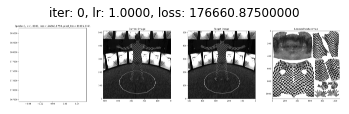

Epoch    12: reducing learning rate of group 0 to 7.5000e-01.


KeyboardInterrupt: 

In [54]:
out_dir = './10_data/output'
save_path = out_dir + '/plot.png'

# filename_output = './4_data/output/4b/out.gif'
# writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}_{:>02}h{:>02}m'.format(now.year, now.month, now.day, hour, minute)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
print('Log output: {}'.format(log_path))

lr = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=10, verbose=True)

print('Model parameters:')
for name, param in model.named_parameters():
    print('  {}, requires_grad={}'.format(name, param.requires_grad))
        
loop = tqdm_notebook(range(1000000000))

bd = model.batch_dict
save_idx = 0
losses = []
loss_belows, loss_aboves = 0, 0
losses_below, losses_above = [], []
latest_states = {'loss': 0.0}
stat_str = ''
for e in loop:
    output_texels = (e % 10 == 0)
    
    
    loss = 0
    batch_size = model.batch_size
    images = torch.empty(model.n_batch*model.batch_size, model.image_size, model.image_size)
    
    # ========================================================================================================================================= #
    for batch_idx in range(model.n_batch):
        i0 = batch_idx*batch_size
        i1 = i0 + batch_size
        
        t0 = time.time()
        optimizer.zero_grad()
        t1 = time.time()
        model.deform_meshes()

        if output_texels:
            l, imgs, texels, _, loss_dict, log = model(batch_idx, batch_size, deform_mesh=True, learn_texturemap=False, learn_deform=True)
            images[i0:i1] = imgs
            
            latest_states['loss'] += loss
            latest_states['images'] = images.clone()
            latest_states['texels'] = texels.clone()
            latest_states['loss_dict'] = loss_dict
        else:
            l, _, _, stat_gpu, loss_dict, log = model(batch_idx, batch_size, deform_mesh=True, learn_texturemap=False, learn_deform=True)
            latest_states['loss'] += loss
            latest_states['loss_dict'] = loss_dict
        if e > 0 and e % 50 == 0:
            model.save_parameters('./10_data/output/deform_verts.npy')
            model.export_obj('./10_data/output', vt_path='./9_data/input/vt_added/03052Interpo_mm.obj')
        loss += l.data
        t2 = time.time()
        l.backward()
        t3 = time.time()
        optimizer.step()
        t4 = time.time()
        scheduler.step(l)
    # ========================================================================================================================================= #
    
    losses.append(loss)
    losses_below.append(loss_belows)
    losses_above.append(loss_aboves)

    lr = optimizer.param_groups[0]['lr']
    loop.set_description('[{}/{}] lr={:.4f}, loss={:.6f}'.format(e, len(loop), lr, loss))

    if output_texels:
        # Save outputs to create a GIF. 
        t10 = time.time()

        img_idx = bd['img_idx'][save_idx]
        cam_idx = bd['cam_idx'][save_idx]
        img_name = bd['img_name'][save_idx]
        image1 = images.squeeze().detach().cpu().numpy()[save_idx]
        image2 = img_refs[img_name][cam_idx]
        image3 = texels.detach().squeeze().cpu().numpy()
        saved_img = visualize2(e, lr, losses, loss_dict, image1, image2, image3, save_path)
        # image_out = visualize_LR(e, lr, losses, images, texels, save_path)
        plt.figure()
        plt.imshow(saved_img)
        plt.title("iter: %d, lr: %0.4f, loss: %0.8f" % (e, lr, loss))
        plt.grid("off")
        plt.axis("off")
        plt.show()
        plt.close('all')

        texels_np = model.texture_map.detach().cpu().numpy()
        np.save(out_dir + '/texturemap.npy', texels_np)
        del texels_np

        texturemap_out = (255.0*np.clip(model.texture_map.detach().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
        im = Image.fromarray(texturemap_out)
        im.save(out_dir + '/texturemap_learned.png', dpi=(600, 600))
        t11 = time.time()

#             image_out = image_out / 255.0
#             image_out = np.clip(image_out, 0, 1)
#             image_out = img_as_ubyte(image_out)
#             writer.append_data(image_out)
        t12 = time.time()

        __output_log(log_path, '{:03} | plot({:.2f}s) | gif({:.2f}s)\n'.format(e+1, t11-t10, t12-t11))
#             stat_str += '  {:<21}: {}\n'.format('plotting', get_gpu_stats())
        save_idx += 1
        if save_idx >= len(bd['img_idx']):
            save_idx = 0
    # execution time
    t01 = t1-t0
    t12 = t2-t1
    t23 = t3-t2
    t34 = t4-t3
    t5 = time.time()

    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
    mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    __output_log(log_path, '{} | {:03} | {:.2f}s | lr={:.8f} | loss={:.6f} | pixel_l={:.4f} | normal_l={:.4f} | lap_l={:.4f} | zero_grad({:.2f}s) | forward({:.2f}s) | backward({:.2f}s) | step({:.2f}s) | GPU_alloc({:,.2f}Mb), max({:,.2f}Mb) | GPU_cache({:,.2f}Mb), max({:,.2f}Mb)\n'.format(now_str, e+1, t5-t0, lr, loss, loss_dict['pixel'], loss_dict['normal'], loss_dict['laplacian'], t01, t12, t23, t34, mb_alloc, mb_alloc_max, mb_cached, mb_cached_max))

    # clean up
    if output_texels:
        del loss, images, texels
    else:
        del loss

    torch.cuda.empty_cache()
    __output_log(log_path, '{}'.format(stat_str))
    if e > 100:
        break
            
torch.cuda.empty_cache()
# loss, images, texels, stat_str = model()
loss, images, texels = latest_states['loss'], latest_states['images'], latest_states['texels']
print(stat_str)

save_dir = out_dir
for i in range(len(images)):
    print(' ', i+1, end='')
    fig, ax = plt.subplots(1, 2, figsize=(24, 12), tight_layout=True)
    img = images[i].detach().cpu().numpy()
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[0].invert_yaxis()
    ax[1].imshow(img_refs[i], cmap='gray')
    ax[1].invert_yaxis()
    plt.savefig(save_dir + '/compare_cam{}.png'.format(i+1), dpi=300)
print(save_dir)

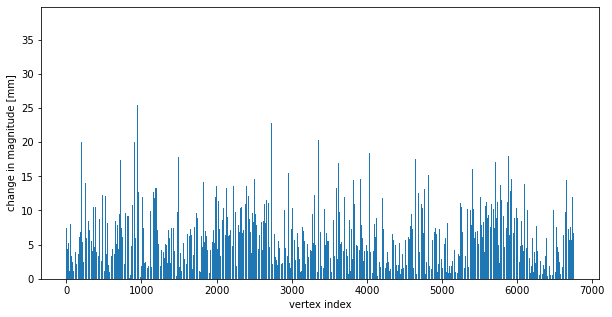

In [25]:
dverts = model.deform_verts
dverts = dverts.detach().cpu().numpy()
dverts_mag = np.linalg.norm(dverts, axis = 1)

plt.figure(figsize=(10, 5))
plt.bar(range(len(dverts_mag)), dverts_mag)
plt.ylabel('change in magnitude [mm]')
plt.xlabel('vertex index')
plt.show()

In [ ]:
# plt.figure()
# # plt.plot(losses, 'k')
# plt.plot(losses_above, 'r')
# plt.plot(losses_below, 'b')

In [ ]:
torch.cuda.empty_cache()
# loss, images, texels, stat_str = model()
loss, images, texels = latest_states['loss'], latest_states['images'], latest_states['texels']

In [ ]:
texture_maps = texels.detach().squeeze().cpu()
td = texels.detach().cpu()
print(td.shape)
print(torch.min(td),',', torch.max(td))

td_a = torch.clamp(-1.0*texture_maps, min=0.0)
print('n_above:', torch.sum(td_a > 0.0))
td_b = torch.clamp(texture_maps, min=1.0) - torch.ones(texture_maps.shape)
print('n_below:', torch.sum(td_b > 1.0))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(td_a, vmin=0, vmax=1.0)
ax[0].set_title('Pixels > 1.0')
ax[1].imshow(td_b, vmin=0, vmax=1.0)
ax[1].set_title('Pixels < 0.0')
plt.figure()
plt.imshow(td.clone().squeeze().numpy(), cmap='gray', vmin=0, vmax=1.0)

### save rendered images

In [ ]:
save_dir = out_dir
            
img_idx = bd['img_idx']
cam_idx = bd['cam_idx']
img_name = bd['img_name']
for n in range(len(img_idx)):
    cam_i = cam_idx[n]
    name = img_name[n]
    print(' ', n+1, end='')
    if n > 0 and n % 16 == 0:
        print()
    fig, ax = plt.subplots(1, 2, figsize=(24, 12), tight_layout=True)
    img = images[n].detach().cpu().numpy()
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=1.0)
    ax[0].invert_yaxis()
    ax[0].invert_xaxis()
    ax[1].imshow(img_refs[name][cam_i], cmap='gray')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    plt.savefig(save_dir + '/compare_cam{}.png'.format(n+1), dpi=300)
print(save_dir)

### visualize

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(16, 1, figsize=(15, 140))
ax = ax.ravel()
for i in range(len(ax)):
    img_mesh = images_rendered[i]
    img_mesh = cv2.flip(img_mesh, -1)
    img_bg = image_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    ax[i].imshow(img_bg)

    img_mesh_large = np.zeros(img_bg.shape)
    img_mesh_padded = cv2.copyMakeBorder(img_mesh, 0, 0, int((4000-2160)/2), int((4000-2160)/2), 0, None, [0, 0, 0])
    ax[i].imshow(img_mesh, alpha=0.5)
    
    pts = mesh_points[i]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * rendered_image_size/2160
    pts_small_y = pts[:, 1] * rendered_image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
#     ax[i].scatter(pts[:, 0], pts[:, 1], c='r', s=0.1)
#     ax[i].scatter(pts_small[:, 0], pts_small[:, 1], c='r', s=0.01)
    ax[i].set_title('Camera {}'.format(cams[i]))
    
    # plot centers
    ax[i].scatter(pts_center[0], pts_center[1], c='r')


In [ ]:
writer.close()

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, image_refs, renderers, texture_maps):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderers = renderers
        self.register_buffer('image_refs', image_refs)

        self.texture_maps = nn.Parameter(texture_maps.to(meshes.device), requires_grad=True)
        
    def forward(self):
        loss = 0
        images = []
        for i in range(len(self.renderers)):
            image = self.renderers[i](meshes_world=self.meshes, texture_maps=self.texture_maps)
            loss_i = torch.mean((image.squeeze()[..., :3] - self.image_refs[i]) ** 2)
            images.append(image)
            loss = loss + loss_i
        loss /= len(self.renderers)

        return loss, images, self.texture_maps.data

# After traning

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

In [ ]:
plt.figure()
plt.imshow(model.texture_maps.detach().cpu().numpy()[0, :, :, :])
plt.savefig('./4_data/output/4b/texturemap_learned.png', dpi=600)
plt.show()

In [ ]:
x = torch.randn((1, 1), requires_grad=True)
with torch.autograd.profiler.profile() as prof:
    print(prof)
    for _ in range(100):  # any normal python code, really!
        y = x ** 2
        y.backward()
# NOTE: some columns were removed for brevity
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

In [ ]:
torch.cuda.memory_stats(device=device_gpu)

In [ ]:
print(torch.cuda.memory_summary(device=device_gpu, abbreviated=True))

In [ ]:
mem_stats = torch.cuda.memory_stats(device=device_gpu)
for k, v in mem_stats.items():
    print('{}: {}'.format(k, v))

In [ ]:
print(torch.cuda.max_memory_allocated(device=device_gpu))